<font size=7 color ="#5499C7" >AI CA1 - Genetic Algorithms</font>
- <font size=5>__Name__ : Kourosh Sajjadi</font>
- <font size=5>__UID__  : 810100587</font>

<font size="5" color="#A9CCE3">Section 0: Basic Concepts and Problem Goals</font>
- Genetic algorithms typically represent a problem through chromosomes and genes to simulate natural selection, as observed in nature. In this computer assignment, we will model the fractional knapsack problem using chromosomes, enabling its solution through genetic algorithms.

<font size="5" color="#A9CCE3">Section 1: Chromosome and Genes Definition</font>

- Initially, we must define our *chromosomes* and *genes*.
- A chromosome is composed of genes, each representing the **maximum number of snacks**. Furthermore, each gene is characterized by the **percentage of that snack we take**.
- <font color="#D2B4DE">(The index indicates which snack we are selecting)</font>


In [26]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from CA1 import fractional_knapsack_with_n_items, data_sorted

In [27]:
POPULATIONSIZE = 300
CROSSOVERPROBABILITY = 0.8
MUTATIONPROBABILITY = 0.02
NUMBEROFROUNDS = 500

MAXWEIGHT = 50
MINVALUE = 60
SNACKSRANGE = (14,17)

In [28]:
csvPath = "snacks.csv"

# Dictionary [Snack, Available Weight, Value]
data = []
Weights = []
Values = []

with open(csvPath, mode='r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        data.append(row)

for item in data:
    Weights.append(int(item.get("Available Weight")))
    Values.append(int(item.get("Value")))

total_value, total_weight, items_selected = fractional_knapsack_with_n_items(data_sorted, MAXWEIGHT, SNACKSRANGE[1])

In [29]:
class Chromosome:
    def __init__(self, genes, weights, values, snackRange):
        if(not genes):
            return

        numOfItemsToPick = random.randint(snackRange[0], snackRange[1])
        selectedIndexes = random.sample(range(len(genes)), numOfItemsToPick)

        self.genes = [gene if i in selectedIndexes else 0 for i, gene in enumerate(genes)]

        self.totalWeight = sum(gene * weight for gene, weight in zip(self.genes, weights))
        self.totalValue = sum(gene * value for gene, value in zip(self.genes, values))

        if self.totalWeight > MAXWEIGHT or self.totalValue < MINVALUE:
            self.fitness = 0
        else:
            self.fitness = self.totalValue

    def changeGenes(self, newGenes):
        self.genes = newGenes
        itemsPicked = sum(1 for gene in self.genes if gene > 0)

        while itemsPicked < SNACKSRANGE[0]:
            zeroIndices = [i for i, gene in enumerate(self.genes) if gene == 0]
            if zeroIndices:
                indexToAdd = random.choice(zeroIndices)
                self.genes[indexToAdd] = random.random()
                itemsPicked += 1

        while itemsPicked > SNACKSRANGE[1]:
            nonZeroIndices = [i for i, gene in enumerate(self.genes) if gene > 0]
            if nonZeroIndices:
                indexToRemove = random.choice(nonZeroIndices)
                self.genes[indexToRemove] = 0
                itemsPicked -= 1

        self.totalWeight = sum(gene * weight for gene, weight in zip(self.genes, Weights))
        self.totalValue = sum(gene * value for gene, value in zip(self.genes, Values))

        if self.totalWeight > MAXWEIGHT or self.totalValue < MINVALUE:
            self.fitness = 0
        else:
            self.fitness = self.totalValue

    def showItems(self):
        for i, gene in enumerate(self.genes):
            if gene != 0:
                print(f"{data[i]['Snack']}: {gene * Weights[i]}")

    def isAlive(self):
        return self.fitness != 0

    def showGenes(self):
        print(self.genes)

    def __str__(self):
        return f"FITNESS = {self.fitness}"

<font size="5" color="#A9CCE3">Section 2: Creating The Initial Population</font>

- The initial population is generated by assigning a **random number between 0 and 1** to each gene. This number represents the *fraction of the item* we plan to include in our fractional knapsack. Other constraints, such as value and range, are enforced within the `Chromosome` class itself.


In [30]:
chromosomes = []
for _ in range(POPULATIONSIZE):
    genes = [round(random.random(), 3) for _ in range(len(Weights))]
    chromosome = Chromosome(genes, Weights, Values, SNACKSRANGE)
    chromosomes.append(chromosome)

<font size="5" color="#A9CCE3">Section 3: Defining The Fitness Function</font>

- The fitness function is defined by the **value that each chromosome represents**. This implementation is located within the `Chromosome` class. Should the total value fall **below the minimum** threshold or the total weight exceed **the maximum** allowable, the **fitness will be set to 0**. This ensures that chromosomes not meeting the criteria have a diminished likelihood of proceeding to subsequent generations.


In [31]:
for chromosome in chromosomes:
    if chromosome.isAlive():
        print(chromosome)

<font size="5" color="#A9CCE3">Section 4: Selection, Crossover, and Mutation</font>

- For **selection**, we explore both **ranking selection** and **roulette selection** techniques. Similarly, in the case of **crossover**, both the **n-point method** and the **uniform method** are examined. The approach involves simply altering the `fractions randomly`. For mutation, a similar strategy is employed, where we **randomly change the fraction** at a random index.


In [32]:
def rankSelection(chromosomes, selectionSize):
    sortedChromosomes = sorted(chromosomes, key=lambda x: x.fitness, reverse=True)

    totalChromosomes = len(sortedChromosomes)
    selectionProbabilities = []
    s = 1.5

    for rank in range(totalChromosomes):
        probability = (2 - s) / totalChromosomes + (2 * rank * (s - 1)) / (totalChromosomes * (totalChromosomes - 1))
        selectionProbabilities.append(probability)

    selectedChromosomes = random.choices(sortedChromosomes, weights=selectionProbabilities, k=selectionSize)

    return selectedChromosomes[:selectionSize]

def rouletteWheelSelection(chromosomes, selectionSize):
    totalFitness = sum(chromosome.fitness for chromosome in chromosomes)

    if totalFitness == 0:
        selectedIndexes = random.choices(range(len(chromosomes)), k=selectionSize)
    else:
        selectionProbs = [chromosome.fitness / totalFitness for chromosome in chromosomes]
        selectedIndexes = random.choices(range(len(chromosomes)), weights=selectionProbs, k=selectionSize)

    return [chromosomes[i] for i in selectedIndexes]

def nPointCrossover(parent1, parent2, points):
    genes1, genes2 = parent1.genes[:], parent2.genes[:]
    crossoverPoints = sorted(random.sample(range(len(genes1)), points))
    for i in range(0, len(crossoverPoints)):
        start = crossoverPoints[i]
        end = crossoverPoints[i+1] if i+1 < len(crossoverPoints) else len(genes1)
        genes1[start:end], genes2[start:end] = genes2[start:end], genes1[start:end]
    return genes1, genes2

def uniformCrossover(parent1, parent2, swap_prob=0.5):
    genes1, genes2 = [], []

    for gene1, gene2 in zip(parent1.genes, parent2.genes):
        if random.random() < swap_prob:
            genes1.append(gene2)
            genes2.append(gene1)
        else:
            genes1.append(gene1)
            genes2.append(gene2)

    return genes1, genes2

def mutate(chromosome, mutation_rate):
    didMutate = False
    mutatedGenes = chromosome.genes[:]

    for i in range(len(mutatedGenes)):
        if random.random() < mutation_rate:
            didMutate = True
            mutatedGenes[i] = random.random()

    return didMutate, mutatedGenes

<font size ="5" color ="#A9CCE3">Section 5: Running The Genetic Algorithm</font>
- Now, by combining all the components we have developed, we simply run the algorithm, generating a new population in each iteration, until a satisfactory solution emerges.

In [33]:
def runGeneticAlgorithm(selection, crossover, crossoverParam, doPrint, fully, popSize = 0, crossProb = 0,
                        mutateProb = 0, numOfRounds = 0):
    global chromosomes

    numOfRoundsO = numOfRounds if numOfRounds != 0 else NUMBEROFROUNDS
    popSizeO = popSize if popSize != 0 else POPULATIONSIZE
    crossProbO = crossProb if crossProb != 0 else CROSSOVERPROBABILITY
    mutateProbO = mutateProb if mutateProb != 0 else MUTATIONPROBABILITY

    overallBestChromosome = None

    for genRound in range(numOfRoundsO):
        selectedChromosomes = selection(chromosomes, popSizeO)
        random.shuffle(selectedChromosomes)

        newGeneration = []

        while len(newGeneration) < popSizeO:
            for i in range(0, len(selectedChromosomes), 2):

                if i+1 < len(selectedChromosomes):
                    child1, child2 = Chromosome([], Weights, Values, SNACKSRANGE), Chromosome([], Weights, Values, SNACKSRANGE)
                    parent1, parent2 = selectedChromosomes[i], selectedChromosomes[i+1]

                    if random.random() <= crossProbO:
                        child1Genes, child2Genes = crossover(parent1, parent2, crossoverParam)
                    else:
                        child1Genes, child2Genes = parent1.genes[:], parent2.genes[:]

                    child1.changeGenes(child1Genes)
                    child2.changeGenes(child2Genes)

                    didMutate1, child1MutatedGenes = mutate(child1, mutateProbO)
                    didMutate2, child2MutatedGenes = mutate(child2, mutateProbO)

                    if(didMutate1):
                        child1.changeGenes(child1MutatedGenes)
                    if(didMutate2):
                        child2.changeGenes(child2MutatedGenes)

                    newGeneration.extend([child1, child2])

                    if len(newGeneration) >= popSizeO:
                        break

        chromosomes = newGeneration[:popSizeO]
        bestChromosome = max(chromosomes, key=lambda x: x.fitness)

        if overallBestChromosome is None or bestChromosome.fitness > overallBestChromosome.fitness:
            overallBestChromosome = bestChromosome
        if(fully):
            print(f"ROUND: {genRound} -- BEST ---> {bestChromosome}")

    if(doPrint):
        print(f"OVERALL BEST CHROMOSOME: {overallBestChromosome}")
        print(f"Percentage To Optimum : {overallBestChromosome.fitness / total_value}")
        overallBestChromosome.showItems()

    return overallBestChromosome.fitness

<font size ="5" color ="#A9CCE3">Section 6: Analyzing The Results</font>
- Finally, we evaluate the performance and accuracy of our genetic algorithm based on the different selection, crossover, and mutation strategies that we implemented. This analysis involves comparing the fitness scores, convergence rates, and overall robustness of each method to determine the most effective approach for our problem.

- By examining the outcomes, we can identify which combinations of genetic operations lead to the best solutions and under what conditions our algorithm performs optimally. This step is crucial for understanding the strengths and weaknesses of our genetic algorithm and for making any necessary adjustments to improve its performance.

Roulette Wheel With nPoint Crossover
OVERALL BEST CHROMOSOME: FITNESS = 69.8366181661749
Percentage To Optimum : 0.9699530300857625
MazMaz: 1.9177329945275223
Nani: 3.2151630530467434
Jooj: 6.91586073296684
Hot-Dog: 0.49617453753748597
Shokolat: 4.52378081615489
Chocoroll: 8.237359032873274
Abnabat: 0.15337742472494087
Adams-Khersi: 0.112
Popcorn: 0.4822628240925777
Pastil: 2.8989852629498953
Masghati: 4.641270681742716
Ghottab: 6.70309564643965
Saghe-Talaei: 8.590157548876627
Choob-Shoor: 0.24378019871743795

Roulette Wheel With Uniform Crossover
OVERALL BEST CHROMOSOME: FITNESS = 70.5875593894841
Percentage To Optimum : 0.9803827692983903
MazMaz: 2.661624385518616
Nani: 0.6252799147064991
Jooj: 6.91586073296684
Chips: 0.15184422144051268
Shokolat: 4.762926038699976
Chocoroll: 8.946254343335177
Cookies: 1.6777658910053874
Abnabat: 0.98500546240022
Adams-Khersi: 0.112
Popcorn: 0.4822628240925777
Pastil: 2.9392718199144094
Masghati: 3.2794626678380028
Ghottab: 6.93754217922626
Saghe-Tal

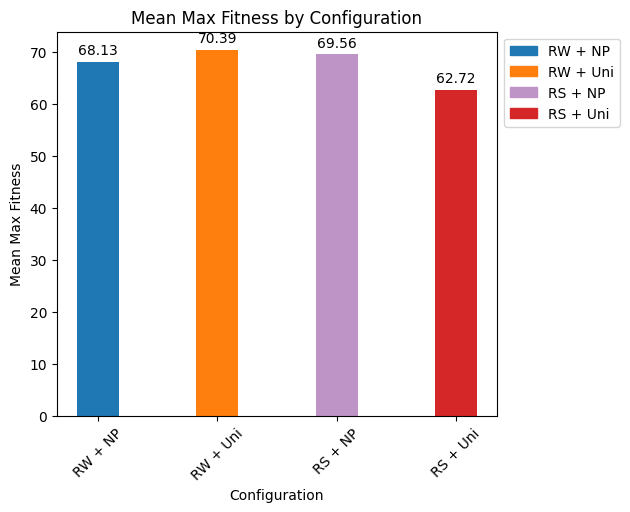

In [34]:
rwNP = []
rwUNI = []
rsNP = []
rsUNI = []

print("Roulette Wheel With nPoint Crossover")
runGeneticAlgorithm(rouletteWheelSelection, nPointCrossover, 3, True, False)
print()
print("Roulette Wheel With Uniform Crossover")
runGeneticAlgorithm(rouletteWheelSelection, uniformCrossover, 0.5, True, False)
print()
print("Rank System With nPoint Crossover")
runGeneticAlgorithm(rankSelection, nPointCrossover, 3, True, False)
print()
print("Rank System With Uniform Crossover")
runGeneticAlgorithm(rankSelection, uniformCrossover, 0.5, True, False)

for _ in range(5):
    rwNP.append(runGeneticAlgorithm(rouletteWheelSelection, nPointCrossover, 3, False, False))
    rwUNI.append(runGeneticAlgorithm(rouletteWheelSelection, uniformCrossover, 0.5, False, False))
    rsNP.append(runGeneticAlgorithm(rankSelection, nPointCrossover, 3, False, False))
    rsUNI.append(runGeneticAlgorithm(rankSelection, uniformCrossover, 0.5, False, False))

maxFitness = {
    'RW + NP': rwNP,
    'RW + Uni': rwUNI,
    'RS + NP': rsNP,
    'RS + Uni': rsUNI
}

meanFitness = {key: np.mean(value) for key, value in maxFitness.items()}

labels = list(meanFitness.keys())
means = list(meanFitness.values())

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
bars = ax.bar(x, means, width, color=['#1f77b4', '#ff7f0e', '#be93c5', '#d62728'])

ax.set_xlabel('Configuration')
ax.set_ylabel('Mean Max Fitness')
ax.set_title('Mean Max Fitness by Configuration')
ax.set_xticks(x)
ax.set_xticklabels(labels)

legendPatches = [
    mpatches.Patch(color='#1f77b4', label='RW + NP'),
    mpatches.Patch(color='#ff7f0e', label='RW + Uni'),
    mpatches.Patch(color='#be93c5', label='RS + NP'),
    mpatches.Patch(color='#d62728', label='RS + Uni')
]

ax.legend(handles=legendPatches, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0, 0, 0.75, 1])

for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(round(height, 2)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()

plt.xticks(rotation=45)
plt.show()

In [35]:
print(f"Total Value: {total_value}")
print(f"Total Weight: {total_weight}")
for item in items_selected:
    print(f"Item: {item[0]}, Weight taken: {item[1]}, Value: {item[2]}, Fraction taken: {item[3]}")

Total Value: 72.0
Total Weight: 50.0
Item: Pastil, Weight taken: 3, Value: 7, Fraction taken: 1
Item: Jooj, Weight taken: 7, Value: 15, Fraction taken: 1
Item: Ghottab, Weight taken: 7, Value: 10, Fraction taken: 1
Item: Chocoroll, Weight taken: 9, Value: 12, Fraction taken: 1
Item: Saghe-Talaei, Weight taken: 9, Value: 11, Fraction taken: 1
Item: Masghati, Weight taken: 5, Value: 6, Fraction taken: 1
Item: Shokolat, Weight taken: 6, Value: 7, Fraction taken: 1
Item: MazMaz, Weight taken: 4.0, Value: 4.0, Fraction taken: 0.4


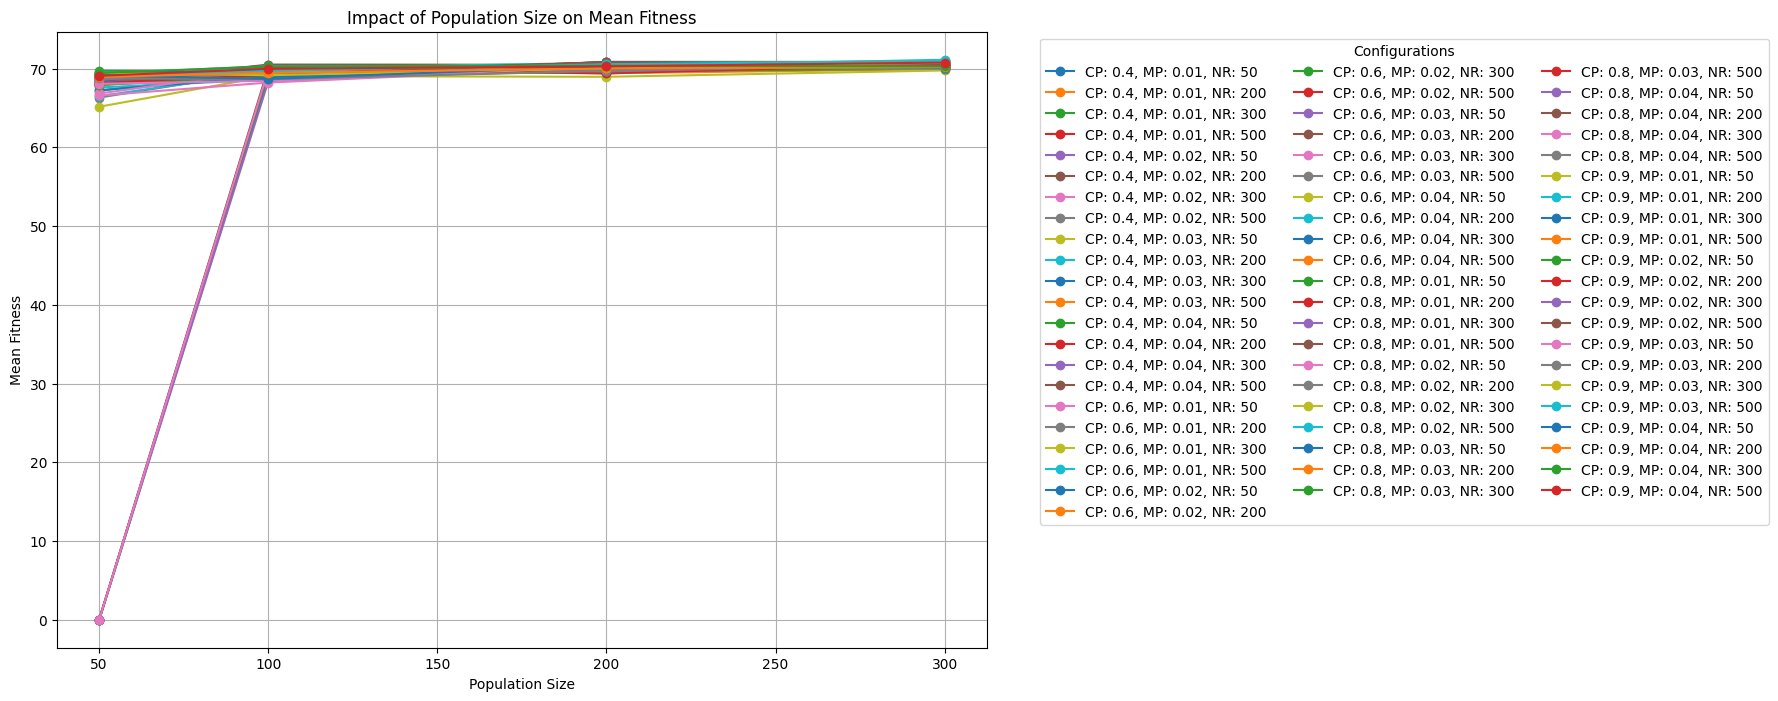

<Figure size 1200x800 with 0 Axes>

Output(layout=Layout(height='450px', overflow='scroll', width='950px'))

In [36]:
populationSizes = [50, 100, 200, 300]
crossoverProbs = [0.4, 0.6, 0.8, 0.9]
mutationProbs = [0.01, 0.02, 0.03, 0.04]
numRoundsList = [50, 200, 300, 500]

results = {
    'populationSize': [],
    'crossoverProb': [],
    'mutationProb': [],
    'numRounds': [],
    'meanFitness': []
}

for popSize in populationSizes:
    for crossProb in crossoverProbs:
        for mutateProb in mutationProbs:
            for numOfRounds in numRoundsList:
                fitnesses = []
                for _ in range(1):
                    fitness = runGeneticAlgorithm(rouletteWheelSelection, uniformCrossover, 0.5, False, False, 
                                                  popSize, crossProb, mutateProb, numOfRounds)
                    fitnesses.append(fitness)

                meanFitness = np.mean(fitnesses)

                results['populationSize'].append(popSize)
                results['crossoverProb'].append(crossProb)
                results['mutationProb'].append(mutateProb)
                results['numRounds'].append(numOfRounds)
                results['meanFitness'].append(meanFitness)

dfResults = pd.DataFrame(results)

plt.figure(figsize=(12, 8))
for crossProb in crossoverProbs:
    for mutateProb in mutationProbs:
        for numOfRounds in numRoundsList:
            dfFiltered = dfResults[(dfResults['crossoverProb'] == crossProb) &
                                     (dfResults['mutationProb'] == mutateProb) &
                                     (dfResults['numRounds'] == numOfRounds)]
            plt.plot(dfFiltered['populationSize'], dfFiltered['meanFitness'], marker='o', label=f'CP: {crossProb}, MP: {mutateProb}, NR: {numOfRounds}')

plt.title('Impact of Population Size on Mean Fitness')
plt.xlabel('Population Size')
plt.ylabel('Mean Fitness')
plt.legend(title='Configurations', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)
plt.grid(True)
plt.figure(figsize=(12, 8))
plt.tight_layout()
plt.show()

out = widgets.Output(layout={'width': '950px', 'height': '450px', 'overflow': 'scroll'})
with out:
    display(dfResults.sort_values(by='meanFitness', ascending=False))
display(out)

<font size="7" color="#5499C7">Questions:</font>

<font size="6" color="#d62b5b">1. How can extremely large or very small population sizes affect the performance of the algorithm?</font>
<div style="text-align: justify;">
    Both extremely small and very large population sizes can negatively impact the performance of the genetic algorithm. A small population size may lack the genetic diversity necessary for finding the optimal solution, leading to a higher risk of getting stuck in local optima. On the other hand, a very large population size, while potentially offering greater diversity and a better chance at finding the optimal solution, significantly increases computational time and resource usage, which may not be justified by the marginal gains in solution quality. Therefore, finding a balance in population size is crucial for the efficiency and effectiveness of the algorithm.
</div>

<font size="6" color="#d62b5b">2. If the population size increases each generation, what effect does it have on the algorithm's accuracy and speed?</font>
<div style="text-align: justify;">
    Gradually increasing the population size each generation can theoretically improve the algorithm's accuracy by introducing more genetic diversity and thereby increasing the chances of finding a better solution. However, this comes at the cost of significantly reducing the algorithm's speed due to the increased computational load of evaluating a larger number of chromosomes in each successive generation. This approach requires careful consideration as the gains in accuracy may not always justify the substantial decrease in computational efficiency. A balanced and static population size is often preferred for maintaining an optimal trade-off between accuracy and speed.
</div>

<font size="6" color="#d62b5b">3. Explain and compare the effects of crossover and mutation operations. Can you use only one of them? Why?</font>
<div style="text-align: justify;">
    Crossover and mutation are two fundamental genetic operators that introduce variability and enable exploration of the solution space. Crossover combines genetic material from two parent chromosomes to produce offspring with potentially superior traits, fostering the exploration of new areas of the solution space. Mutation introduces random alterations to individual chromosomes, ensuring diversity within the population and preventing premature convergence on suboptimal solutions. While it's theoretically possible to run a genetic algorithm using only one of these operations, doing so would severely limit its ability to efficiently explore and exploit the solution space. Crossover without mutation might lead to a rapid loss of diversity, trapping the algorithm in local optima. Conversely, mutation without crossover would rely solely on random alterations for new solutions, significantly slowing down the convergence towards an optimal solution. Therefore, both operators are crucial for balancing exploration and exploitation, ensuring the genetic algorithm can effectively search for and refine solutions.
</div>

<font size="6" color="#d62b5b">4. In your opinion, what solutions exist to reach the answer faster for this specific problem?</font>
<div style="text-align: justify;">
    To expedite finding a solution for this specific problem, several strategies can be employed. Fine-tuning algorithm parameters such as population size, mutation probability, and crossover rate can significantly impact performance and accuracy. Additionally, employing more sophisticated selection techniques to maintain genetic diversity while still promoting the best candidates for reproduction can help. Hybrid approaches that combine genetic algorithms with other optimization methods can also enhance the search efficiency by quickly honing in on promising areas of the solution space. Implementing adaptive mechanisms that adjust parameters dynamically based on the current state of the search could further optimize the exploration and exploitation balance, speeding up the convergence towards the optimal solution, And also for this specific problem if we made our steps 0.1 instead of a 20 percission float we could have reduced the sample space and made our answers more optimum.
</div>

<font size="6" color="#d62b5b">5. Even using these methods, it's possible chromosomes won't change after a few generations. Explain why this happens and the problems it causes. What do you suggest to fix it?</font>
<div style="text-align: justify;">
    The phenomenon where chromosomes stop changing significantly after a few generations is known as convergence or premature convergence. This usually happens when the population loses diversity, and the genetic algorithm starts recycling the same genetic material without making substantial progress towards better solutions. Premature convergence to suboptimal solutions is a common problem that reduces the effectiveness of the algorithm. To combat this issue, strategies such as introducing diversity through higher mutation rates, using diversity-preserving mechanisms like fitness sharing, or periodically injecting new, randomly generated individuals into the population can be effective. Additionally, restarting the algorithm with a new, diverse population if stagnation is detected can help escape local optima and potentially lead to discovering better solutions.
</div>

<font size="6" color="#d62b5b">6. What solution do you propose for terminating the program if the problem has no solution?</font>
<div style="text-align: justify;">
    In cases where it appears that the problem has no solution or the algorithm is unable to find a satisfactory solution within reasonable time frames, implementing a termination condition based on convergence criteria or computational limits is essential. Setting a maximum number of generations or a threshold for minimal improvement over a number of generations can serve as effective stopping criteria. Additionally, monitoring the variance or diversity of the population and terminating the algorithm if it falls below a certain threshold could also indicate that the search has stalled. For problems where it's known in advance that finding an optimal solution might be extremely difficult or impossible, incorporating domain-specific heuristics or fallback strategies to provide the best possible solution under the circumstances, even if not optimal, would be prudent. Ultimately, combining multiple termination criteria can provide a more robust and flexible approach to stopping the algorithm efficiently when further search is deemed unproductive.
</div>
